In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
# Add the path to the utils directory
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'utils')))
from import_funcs import * #list_files_with_extension, extract_data_inline
from calibration_funcs import * 
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from plotting_funcs import plot_all_conditions, plot_condition_classes
from sklearn.linear_model import LinearRegression



In [3]:
path = './data'
txt_files = list_files_with_extension(path, '.txt')

# Add a 'time_index' column before concatenating all_X
all_X = []

for file in txt_files:
    # Extract condition (text after last underscore, before .txt)
    condition = Path(file).stem.split(' ')[-1]
    # Extract data
    idx_start, idx_stop, delta_time, T, X_local = extract_data_inline(file)
    # Drop unwanted columns
    X_local = X_local.drop(columns=['power'])
    # Add time_index column
    X_local = X_local.copy()
    X_local['time_index'] = X_local.index
    # Add condition column
    X_local['condition'] = condition
    all_X.append(X_local)

all_X = pd.concat(all_X, ignore_index=True)

In [4]:
all_X.columns

Index(['V_rad_short', 'V_rad_tot', 'V_housing', 'V_diode', 'V_spike',
       'cooling_flag_1', 'cooling_flag_2', 'time_index', 'condition'],
      dtype='object')

In [5]:
all_X.condition.unique()

array(['25', '50'], dtype=object)

In [6]:
# Define calibration parameters as variables
RadSlopeChange = 0.0006182511106682944  # V/°C²
RadSlope0 = -0.06051481175395883        # V/°C
RadOffsetChange = -0.0009632383570051569 # V/°C
RadOffset0 = 0.2300154917793174         # V
HousingSlope = 98.08555780332561        # °C/V
HousingOffset = -49.81626782454236      # °C

## Plot Values

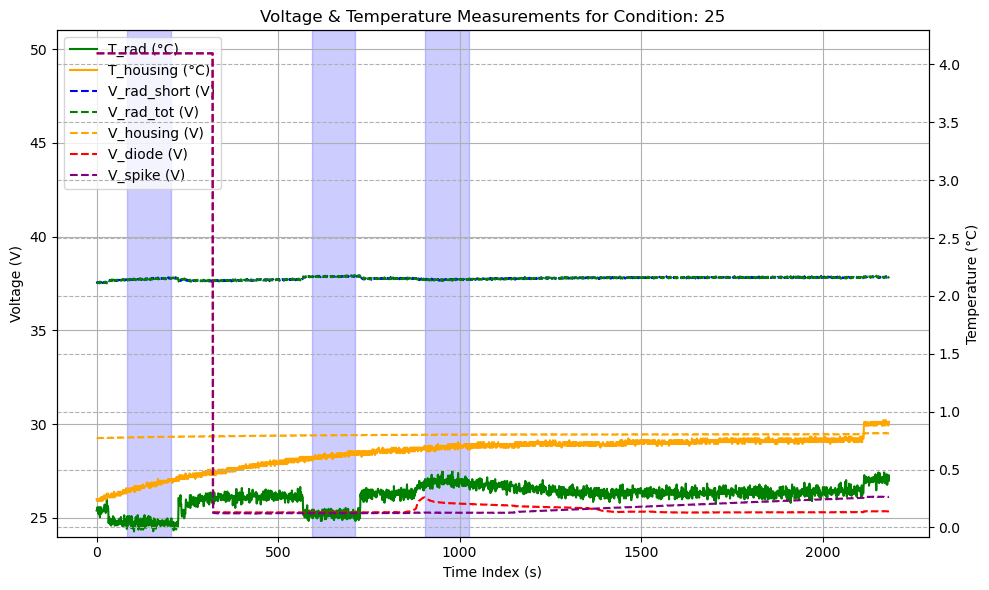

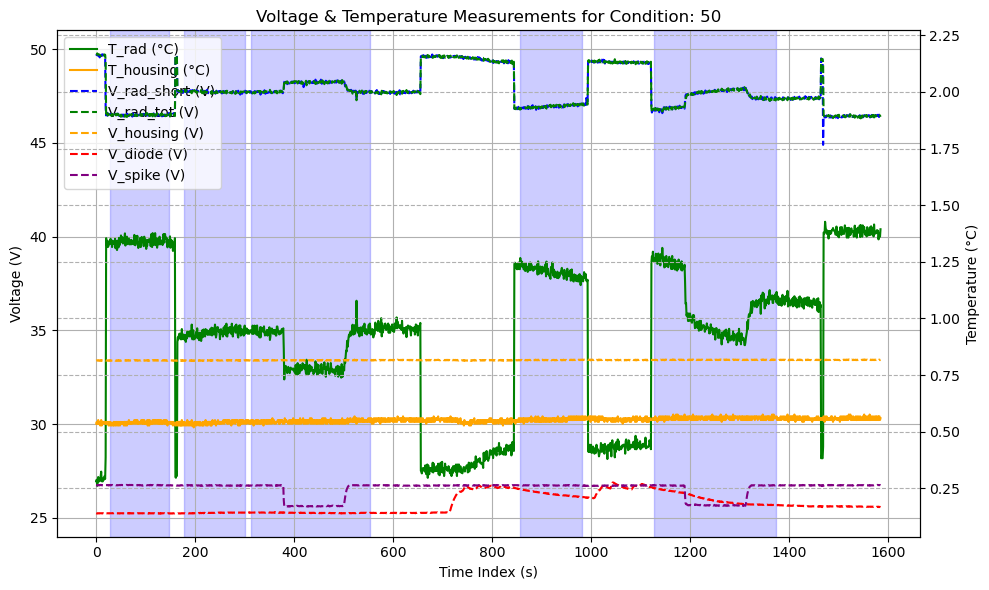

In [7]:
all_X["T_housing"] = T_housing_func(all_X["V_housing"]/1000, HousingSlope, HousingOffset)
all_X["T_rad"] = T_rad_func(all_X["V_rad_tot"]/1000, all_X["T_housing"], RadOffsetChange, RadOffset0, RadSlopeChange, RadSlope0)


variables_right = ['V_rad_short', 'V_rad_tot', 'V_housing', 'V_diode', 'V_spike']
variables_left = ['T_rad', 'T_housing']
y_axes_right_lims = (None, None)
y_axes_left_lims = (24, 51)

variables_colors = {
    'V_rad_short': 'blue',
    'V_rad_tot': 'green',
    'V_housing': 'orange',
    'V_diode': 'red',
    'V_spike': 'purple',
    'T_housing': 'orange',
    'T_rad': 'green',
    'T_antenna': 'purple'
}
labels = {
    'V_rad_short': 'V_rad_short (V)',
    'V_rad_tot': 'V_rad_tot (V)',
    'V_spike': 'V_spike (V)',
    'V_housing': 'V_housing (V)',
    'V_diode': 'V_diode (V)',
    'T_housing': 'T_housing (°C)',
    'T_rad': 'T_rad (°C)',
    'T_antenna': 'T_antenna (°C)'
}

for cond in all_X['condition'].unique():
    subset = all_X[all_X['condition'] == cond]
    fig, ax1 = plt.subplots(figsize=(10, 6))
    for var in variables_left:
        ax1.plot(subset.time_index, subset[var] , label=labels[var], color=variables_colors[var])
    ax1.set_xlabel("Time Index (s)")
    ax1.set_ylabel("Voltage (V)")
    ax1.grid(True)
    ax1.set_ylim(y_axes_left_lims)

    ax2 = ax1.twinx()
    for var in variables_right:
        ax2.plot(subset.time_index, subset[var] / 1000, label=labels[var], linestyle='--', color=variables_colors[var])
    ax2.set_ylabel("Temperature (°C)")
    ax2.grid(True, linestyle='--')
    ax2.set_ylim(y_axes_right_lims)

    # Cooling periods shading
    cooling_periods = subset[subset['cooling_flag_1'] == 1]
    if not cooling_periods.empty:
        cooling_periods = cooling_periods.copy()
        cooling_periods['group'] = (cooling_periods['time_index'].diff() != 1).cumsum()
        for _, group in cooling_periods.groupby('group'):
            start = group['time_index'].min()
            end = group['time_index'].max()
            ax1.axvspan(start, end, color='blue', alpha=0.2)

    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    plt.title(f"Voltage & Temperature Measurements for Condition: {cond}")
    plt.tight_layout()
    plt.show()

In [8]:
# Assign 'class' labels for each condition separately
all_X['class'] = None

for cond in all_X['condition'].unique():
    cond_mask = all_X['condition'] == cond
    cond_df = all_X[cond_mask]
    cooling_periods = cond_df[cond_df['cooling_flag_1'] == 1].copy()
    cooling_periods['group'] = (cooling_periods['time_index'].diff() != 1).cumsum()
    periods = cooling_periods.groupby('group')['time_index'].agg(['first', 'last']).reset_index(drop=True)
    # Use labels list, repeat if needed
    labels_25 = ["cable+load", "cable+antenna", "cable+antenna (hot handle)"]
    labels_50 = ["cable+load", "cable+antenna", "cable+antenna (cooling)", "cable+antenna (hot handle)", "cable+antenna (hot handle and cooling)"]
    if cond == "25":
        cond_labels = labels_25 * ((len(periods) + len(labels_25) - 1) // len(labels_25))
    elif cond == "50":
        cond_labels = labels_50 * ((len(periods) + len(labels_50) - 1) // len(labels_50))
    else:
        raise ImportError("Unknown condition")
    periods['label'] = cond_labels[:len(periods)]
    for _, row in periods.iterrows():
        mask = cond_mask & (all_X['time_index'] >= row['first']) & (all_X['time_index'] <= row['last'])
        all_X.loc[mask, 'class'] = row['label']

for cond in all_X['condition'].unique():
    print(f"\nCondition: {cond}")
    print(all_X[all_X['condition'] == cond]['class'].value_counts(dropna=False))



Condition: 25
class
None                          1818
cable+load                     122
cable+antenna                  122
cable+antenna (hot handle)     122
Name: count, dtype: int64

Condition: 50
class
None                                      727
cable+antenna (hot handle and cooling)    247
cable+antenna (cooling)                   242
cable+antenna (hot handle)                125
cable+antenna                             124
cable+load                                121
Name: count, dtype: int64


In [9]:
# Filter out classes with asterisks and get valid classes for each condition
all_X_clean = all_X[~all_X['class'].str.contains(r'\*', na=False)].copy()

# Remove rows where class is None
all_X_clean = all_X_clean[all_X_clean['class'].notna()].copy()

print("Valid classes by condition:")
conditions = sorted(all_X_clean['condition'].unique())

for cond in conditions:
    print(f"\nCondition: {cond}")
    print(all_X_clean[all_X_clean['condition'] == cond]['class'].value_counts())

Valid classes by condition:

Condition: 25
class
cable+load                    122
cable+antenna                 122
cable+antenna (hot handle)    122
Name: count, dtype: int64

Condition: 50
class
cable+antenna (hot handle and cooling)    247
cable+antenna (cooling)                   242
cable+antenna (hot handle)                125
cable+antenna                             124
cable+load                                121
Name: count, dtype: int64


Axes(0.125,0.53;0.775x0.35)

Condition 25 - Data summary by class:
  cable+load: 122 points, time range: 0.0 - 121.0 s
  cable+antenna: 122 points, time range: 142.0 - 263.0 s
  cable+antenna (hot handle): 122 points, time range: 284.0 - 405.0 s
Axes(0.125,0.11;0.775x0.35)

Condition 50 - Data summary by class:
  cable+load: 121 points, time range: 0.0 - 120.0 s
  cable+antenna: 124 points, time range: 141.0 - 264.0 s
  cable+antenna (cooling): 242 points, time range: 285.0 - 526.0 s
  cable+antenna (hot handle): 125 points, time range: 547.0 - 671.0 s
  cable+antenna (hot handle and cooling): 247 points, time range: 692.0 - 938.0 s


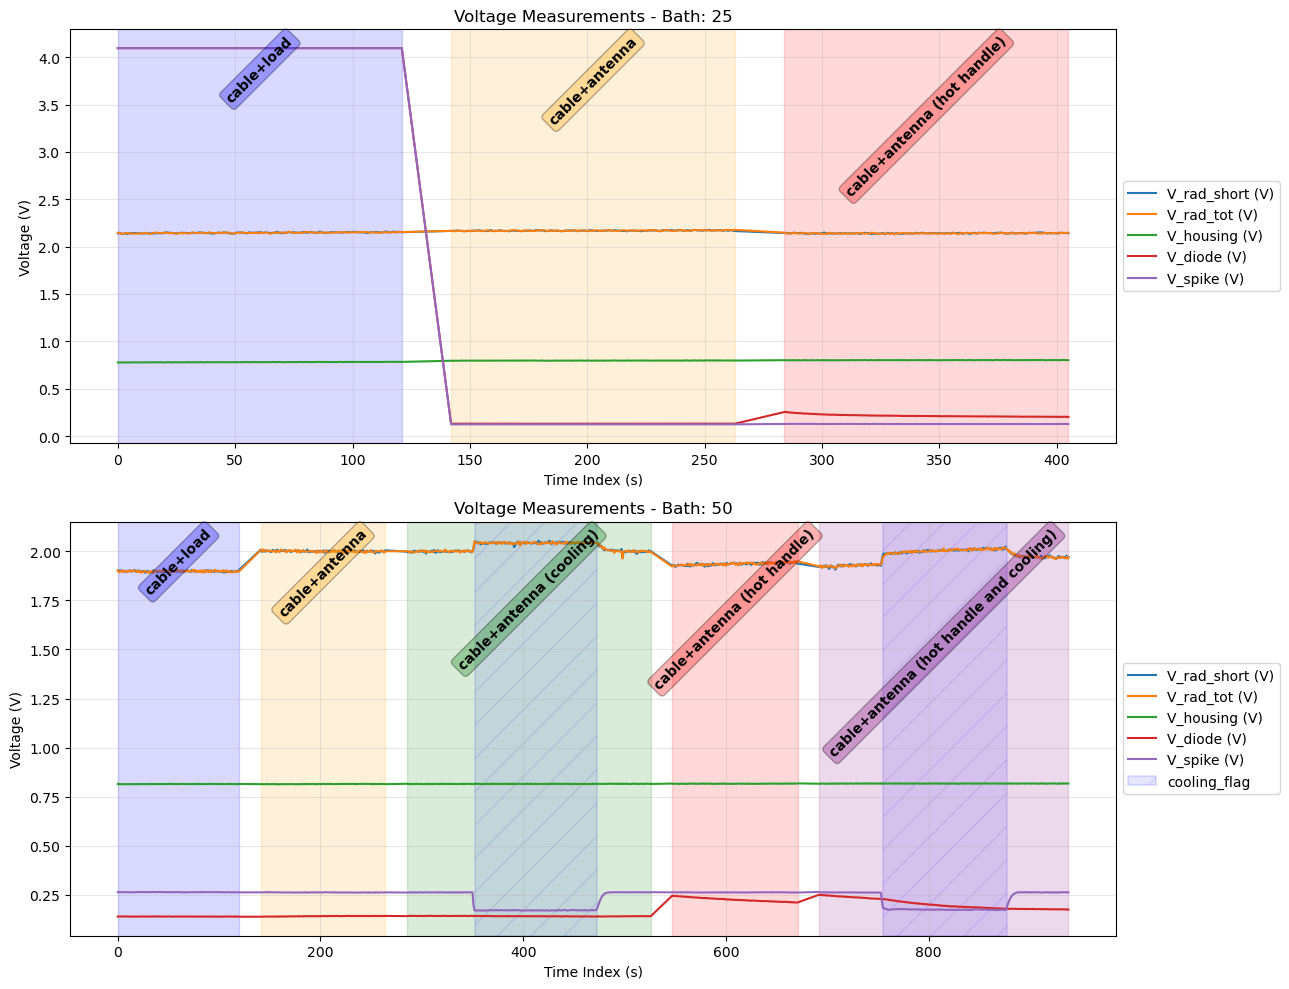

In [10]:
class_order = ["cable+load", "cable+antenna", "cable+antenna (cooling)", "cable+antenna (hot handle)", "cable+antenna (hot handle and cooling)"]
class_colors = {
    'cable+load': 'blue',
    'cable+antenna': 'orange',
    'cable+antenna (cooling)': 'green',
    'cable+antenna (hot handle)': 'red',
    'cable+antenna (hot handle and cooling)': 'purple'
}
variables = ['V_rad_short', 'V_rad_tot', 'V_housing', 'V_diode', 'V_spike']
plot_all_conditions(
    all_X_clean,
    variables,
    labels,
    class_order,
    class_colors,
    gap_duration=20,
    cooling_flag_col='cooling_flag_2',
    time_index_col='time_index_2',
    yscale=1000,
    title_prefix="Voltage Measurements - Bath: ",
    ylabel="Voltage (V)"
)

## Calibrate T antenna

In [11]:
# Calculate average V_rad_tot and V_housing for each condition and class
print("Average voltages by condition and class:")
print("="*50)

avg_voltages_by_condition = {}

for condition in conditions:
    print(f"\nCondition: {condition}")
    condition_data = all_X_clean[all_X_clean['condition'] == condition]
    avg_voltages = condition_data.groupby('class')[['V_rad_tot', 'V_housing', 'V_diode', 'V_spike', 'T_rad', 'T_housing']].mean()
    avg_voltages_by_condition[condition] = avg_voltages

    print("Microvolts:")
    print(avg_voltages.round(1))
    print("-" * 30)

# Get average V_spike for cable+antenna at condition 25 and 50
v_spike_25 = avg_voltages_by_condition["25"].loc['cable+antenna', 'V_spike'] / 1000  # convert to volts
v_spike_50 = avg_voltages_by_condition["50"].loc['cable+antenna', 'V_spike'] / 1000  # convert to volts

# Temperatures
temps = np.array([25, 50])
voltages = np.array([v_spike_25, v_spike_50])

# Linear regression: voltage = slope * temp + offset
reg = LinearRegression().fit(voltages.reshape(-1, 1), temps)
AntennaSlope = reg.coef_[0]
AntennaOffset = reg.intercept_

print(f"AntennaSlope: {AntennaSlope:.6f} °C/V")
print(f"AntennaOffset: {AntennaOffset:.6f} ºC")

Average voltages by condition and class:

Condition: 25
Microvolts:
                            V_rad_tot  V_housing  V_diode  V_spike  T_rad  \
class                                                                       
cable+antenna                  2168.8      796.7    130.3    123.9   25.2   
cable+antenna (hot handle)     2140.4      801.3    215.3    127.7   26.9   
cable+load                     2146.0      780.4   4095.0   4095.0   24.7   

                            T_housing  
class                                  
cable+antenna                    28.3  
cable+antenna (hot handle)       28.8  
cable+load                       26.7  
------------------------------

Condition: 50
Microvolts:
                                        V_rad_tot  V_housing  V_diode  \
class                                                                   
cable+antenna                              1999.6      814.5    141.6   
cable+antenna (cooling)                    2022.0      815.3    141.8

## Calculate $\tau_{\text{C}}$

In [12]:
t_rad_25 = avg_voltages_by_condition["25"].loc['cable+load', 'T_rad']
t_rad_50 = avg_voltages_by_condition["50"].loc['cable+load', 'T_rad']

tau_c = (t_rad_50 - t_rad_25) / (50 - 25)
print(tau_c)

t_cable_25 = (t_rad_25 - 25*tau_c) / (1 - tau_c)
t_cable_50 = (t_rad_50 - 50*tau_c) / (1 - tau_c)

print(t_cable_25, t_cable_50)

0.6002031240153375
24.347722129588234 24.34772212958823


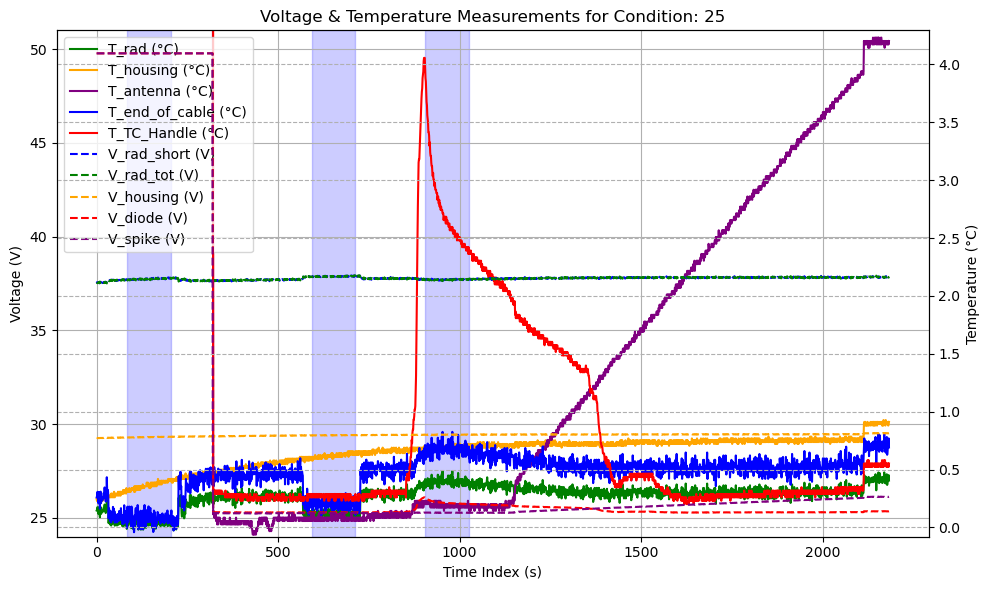

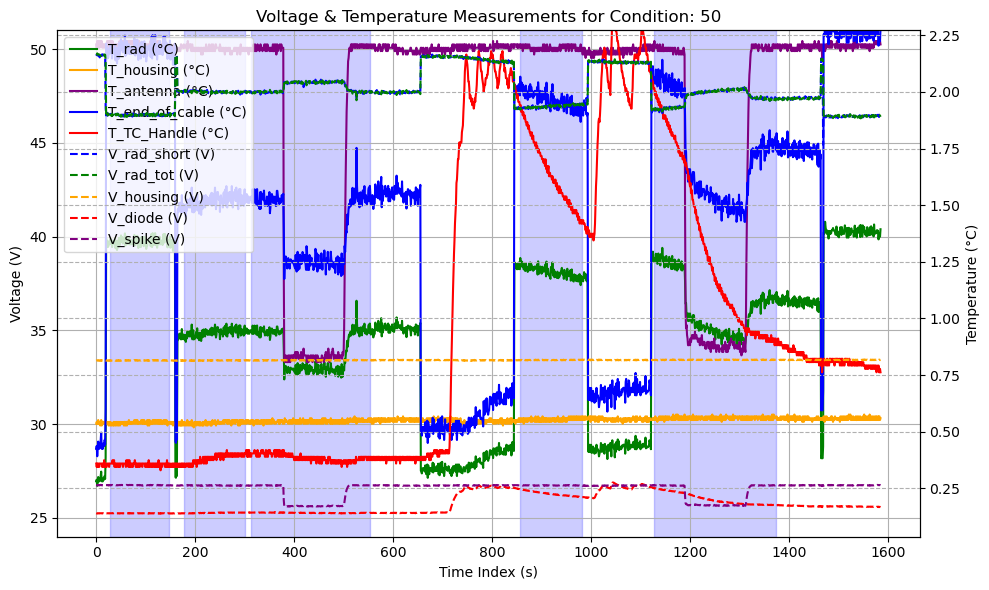

In [32]:
# all_X["T_housing"] = T_housing_func(all_X["V_housing"]/1000, HousingSlope, HousingOffset)
# all_X["T_rad"] = T_rad_func(all_X["V_rad_tot"]/1000, all_X["T_housing"], RadOffsetChange, RadOffset0, RadSlopeChange, RadSlope0)
all_X["T_antenna"] = T_antenna_func(all_X["V_spike"]/1000, AntennaSlope, AntennaOffset) 
all_X["T_end_of_cable"] = T_tissue_cable_func(all_X["T_rad"], t_cable_25, tau_c)
all_X["T_TC_Handle"] = T_antenna_func(all_X["V_diode"]/1000, AntennaSlope, AntennaOffset)
all_X["T_bath"] = all_X["condition"].astype(int)


variables_right = ['V_rad_short', 'V_rad_tot', 'V_housing', 'V_diode', 'V_spike']
variables_left = ['T_rad', 'T_housing', 'T_antenna', 'T_end_of_cable', 'T_TC_Handle']
y_axes_right_lims = (None, None)
y_axes_left_lims = (24, 51)

variables_colors = {
    'V_rad_short': 'blue',
    'V_rad_tot': 'green',
    'V_housing': 'orange',
    'V_diode': 'red',
    'V_spike': 'purple',
    'T_housing': 'orange',
    'T_rad': 'green',
    'T_antenna': 'purple',
    'T_end_of_cable': 'blue',
    'T_TC_Handle': 'red'
}
labels = {
    'V_rad_short': 'V_rad_short (V)',
    'V_rad_tot': 'V_rad_tot (V)',
    'V_spike': 'V_spike (V)',
    'V_housing': 'V_housing (V)',
    'V_diode': 'V_diode (V)',
    'T_housing': 'T_housing (°C)',
    'T_rad': 'T_rad (°C)',
    'T_antenna': 'T_antenna (°C)',
    'T_end_of_cable': 'T_end_of_cable (°C)',
    'T_TC_Handle': 'T_TC_Handle (°C)'
}

for cond in all_X['condition'].unique():
    subset = all_X[(all_X['condition'] == cond)]
    fig, ax1 = plt.subplots(figsize=(10, 6))
    for var in variables_left:
        ax1.plot(subset.time_index, subset[var] , label=labels[var], color=variables_colors[var])
    ax1.set_xlabel("Time Index (s)")
    ax1.set_ylabel("Voltage (V)")
    ax1.grid(True)
    ax1.set_ylim(y_axes_left_lims)

    ax2 = ax1.twinx()
    for var in variables_right:
        ax2.plot(subset.time_index, subset[var] / 1000, label=labels[var], linestyle='--', color=variables_colors[var])
    ax2.set_ylabel("Temperature (°C)")
    ax2.grid(True, linestyle='--')
    ax2.set_ylim(y_axes_right_lims)

    # Cooling periods shading
    cooling_periods = subset[subset['cooling_flag_1'] == 1]
    if not cooling_periods.empty:
        cooling_periods = cooling_periods.copy()
        cooling_periods['group'] = (cooling_periods['time_index'].diff() != 1).cumsum()
        for _, group in cooling_periods.groupby('group'):
            start = group['time_index'].min()
            end = group['time_index'].max()
            ax1.axvspan(start, end, color='blue', alpha=0.2)

    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    plt.title(f"Voltage & Temperature Measurements for Condition: {cond}")
    plt.tight_layout()
    plt.show()

In [14]:
# Filter out classes with asterisks and get valid classes for each condition
all_X_clean = all_X[~all_X['class'].str.contains(r'\*', na=False)].copy()

# Remove rows where class is None
all_X_clean = all_X_clean[all_X_clean['class'].notna()].copy()

print("Valid classes by condition:")
conditions = sorted(all_X_clean['condition'].unique())

for cond in conditions:
    print(f"\nCondition: {cond}")
    print(all_X_clean[all_X_clean['condition'] == cond]['class'].value_counts())

Valid classes by condition:

Condition: 25
class
cable+load                    122
cable+antenna                 122
cable+antenna (hot handle)    122
Name: count, dtype: int64

Condition: 50
class
cable+antenna (hot handle and cooling)    247
cable+antenna (cooling)                   242
cable+antenna (hot handle)                125
cable+antenna                             124
cable+load                                121
Name: count, dtype: int64


Axes(0.125,0.53;0.775x0.35)

Condition 25 - Data summary by class:
  cable+load: 122 points, time range: 0.0 - 121.0 s
  cable+antenna: 122 points, time range: 142.0 - 263.0 s
  cable+antenna (hot handle): 122 points, time range: 284.0 - 405.0 s
Axes(0.125,0.11;0.775x0.35)

Condition 50 - Data summary by class:
  cable+load: 121 points, time range: 0.0 - 120.0 s
  cable+antenna: 124 points, time range: 141.0 - 264.0 s
  cable+antenna (cooling): 242 points, time range: 285.0 - 526.0 s
  cable+antenna (hot handle): 125 points, time range: 547.0 - 671.0 s
  cable+antenna (hot handle and cooling): 247 points, time range: 692.0 - 938.0 s


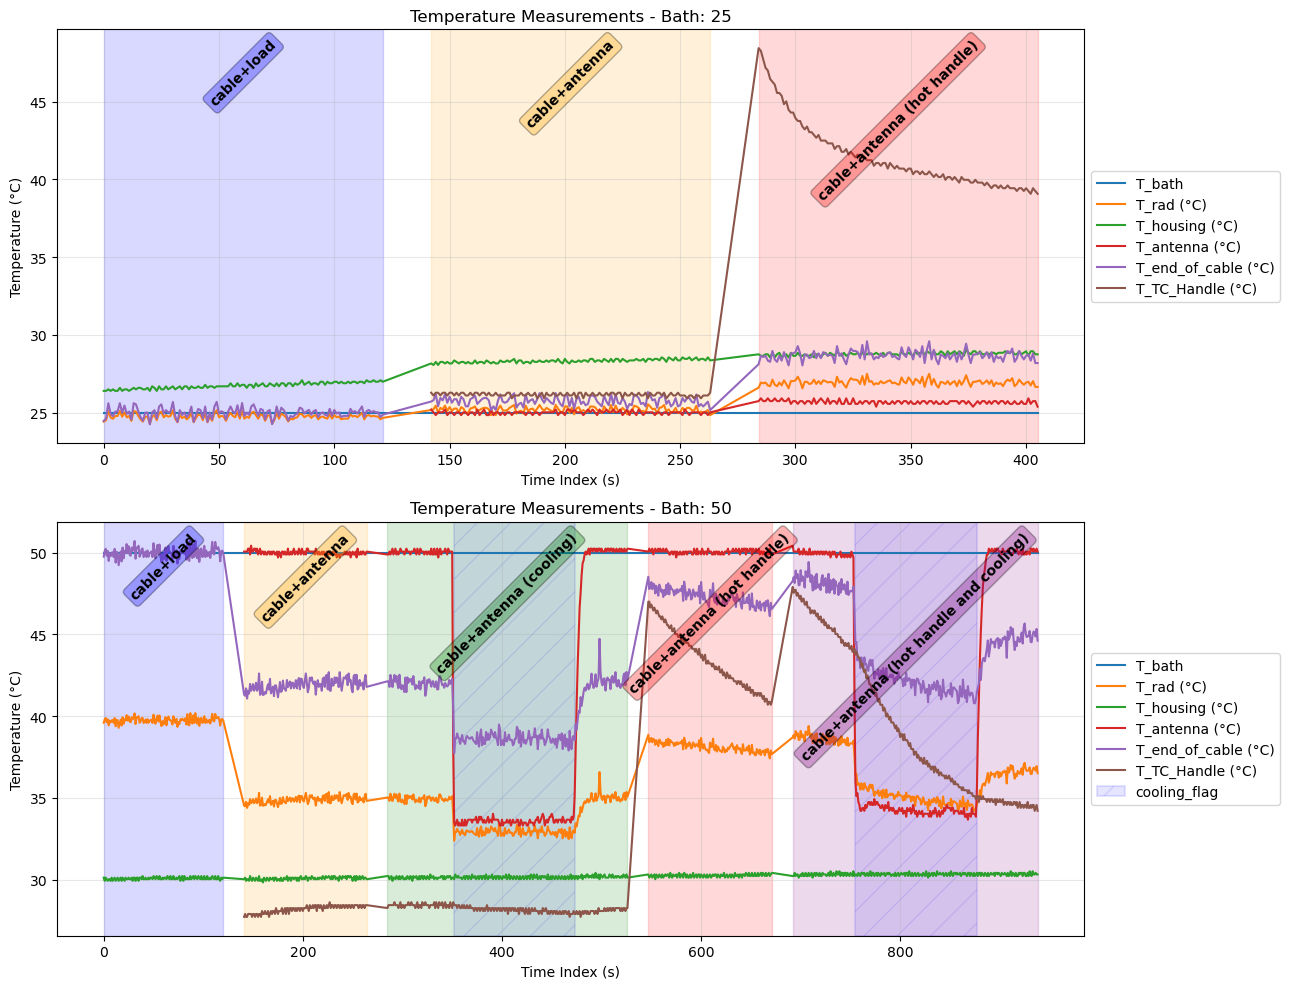

In [15]:
all_X_clean.loc[all_X_clean['class'] == 'cable+load', "T_antenna"] = None
all_X_clean.loc[all_X_clean['class'] == 'cable+load', "T_TC_Handle"] = None


class_order = ["cable+load", "cable+antenna", "cable+antenna (cooling)", "cable+antenna (hot handle)", "cable+antenna (hot handle and cooling)"]
class_colors = {
    'cable+load': 'blue',
    'cable+antenna': 'orange',
    'cable+antenna (cooling)': 'green',
    'cable+antenna (hot handle)': 'red',
    'cable+antenna (hot handle and cooling)': 'purple'
}
variables = ['T_bath', 'T_rad', 'T_housing', 'T_antenna', 'T_end_of_cable', 'T_TC_Handle']
plot_all_conditions(
    all_X_clean,
    variables,
    labels,
    class_order,
    class_colors,
    gap_duration=20,
    yscale=1,
    cooling_flag_col='cooling_flag_2',
    time_index_col='time_index_2',
    title_prefix="Temperature Measurements - Bath: ",
    ylabel="Temperature (°C)"
)

In [16]:
print("Average temperatures by condition and class:")
print("="*50)

avg_temps_by_condition = {}

for condition in conditions:
    print(f"\nCondition: {condition}")
    condition_data = all_X_clean[all_X_clean['condition'] == condition]
    avg_temps = condition_data.groupby('class')[['T_rad', 'T_housing', 'T_antenna', 'T_end_of_cable']].mean()
    avg_temps_by_condition[condition] = avg_temps

    print("Microvolts:")
    print(avg_temps.round(1))
    print("-" * 30)


Average temperatures by condition and class:

Condition: 25
Microvolts:
                            T_rad  T_housing  T_antenna  T_end_of_cable
class                                                                  
cable+antenna                25.2       28.3       25.0            25.8
cable+antenna (hot handle)   26.9       28.8       25.7            28.7
cable+load                   24.7       26.7        NaN            25.0
------------------------------

Condition: 50
Microvolts:
                                        T_rad  T_housing  T_antenna  \
class                                                                 
cable+antenna                            34.9       30.1       50.0   
cable+antenna (cooling)                  33.9       30.1       41.5   
cable+antenna (hot handle and cooling)   36.3       30.3       42.0   
cable+antenna (hot handle)               38.1       30.3       50.1   
cable+load                               39.7       30.1        NaN   

            

## Calculating tau handle and tau antenna

In [18]:
vna_excel_path = Path("/Users/mcy/Library/CloudStorage/OneDrive-HEPTAMEDICAL/HEPTA ADMIN - presentation_Manuel/VNA/VNA Measurements.xlsx")
vna_data = pd.read_excel(vna_excel_path)

date = "Aug 27 2025"
tau_antenna_in_dB = vna_data[(vna_data['DUT'] == 'Antenna') & (vna_data["Date"] == date)]['S11 Mod (dB)'].values[0] / 2
tau_antenna = 10**(tau_antenna_in_dB/10)
print(f"Antenna measured S21: {tau_antenna_in_dB:.3f}")
print(f"Antenna measured transmission: {tau_antenna:.3f}")
antenna_l = 34 # cm
antenna_l_in_feet = antenna_l / 30.48
tau_antenna_in_dB_theoretical = -0.8879088 * antenna_l_in_feet
tau_antenna_theoretical = 10**(tau_antenna_in_dB_theoretical/10)
print(f"Antenna theoretical S21: {tau_antenna_in_dB_theoretical:.3f}")
print(f"Antenna theoretical transmission: {tau_antenna_theoretical:.3f}")
tau_antenna = tau_antenna_theoretical
tau_handle = 10**((tau_antenna_in_dB - tau_antenna_in_dB_theoretical)/10)
print(f"Handle theoretical transmission: {tau_handle:.3f}")

Antenna measured S21: -1.708
Antenna measured transmission: 0.675
Antenna theoretical S21: -0.990
Antenna theoretical transmission: 0.796
Handle theoretical transmission: 0.848


In [19]:
T_eoc_cold = np.mean(all_X_clean[(all_X_clean['condition'] == '25') & (all_X_clean['class'] == 'cable+antenna')]['T_end_of_cable'])
T_eoc_hot_coff = np.mean(all_X_clean[(all_X_clean['condition'] == '50') & (all_X_clean['class'] == 'cable+antenna')]['T_end_of_cable'])
T_eoc_hot_con = np.mean(all_X_clean[(all_X_clean['condition'] == '50') & (all_X_clean['class'] == 'cable+antenna (cooling)') & (all_X_clean['cooling_flag_2'] == 1)]['T_end_of_cable'])
T_a_cold = np.mean(all_X_clean[(all_X_clean['condition'] == '25') & (all_X_clean['class'] == 'cable+antenna')]['T_antenna'])
T_a_hot_coff = np.mean(all_X_clean[(all_X_clean['condition'] == '50') & (all_X_clean['class'] == 'cable+antenna')]['T_antenna'])
T_a_hot_con = np.mean(all_X_clean[(all_X_clean['condition'] == '50') & (all_X_clean['class'] == 'cable+antenna (cooling)') & (all_X_clean['cooling_flag_2'] == 1)]['T_antenna'])
# T_a_coff = 

print(T_a_cold, T_eoc_hot_coff, T_eoc_hot_con)
print(T_a_cold, T_a_hot_coff, T_a_hot_con)

T_h_cold = np.mean(all_X_clean[(all_X_clean['condition'] == '25') & (all_X_clean['class'] == 'cable+antenna')]['T_TC_Handle'])
T_h_hot_coff = np.mean(all_X_clean[(all_X_clean['condition'] == '50') & (all_X_clean['class'] == 'cable+antenna')]['T_TC_Handle'])
T_h_hot_con = np.mean(all_X_clean[(all_X_clean['condition'] == '50') & (all_X_clean['class'] == 'cable+antenna (cooling)') & (all_X_clean['cooling_flag_2'] == 1)]['T_TC_Handle'])

print(T_h_cold, T_h_hot_coff, T_h_hot_con)


25.0 41.90963050632922 38.61690434872953
25.0 50.0 33.59394882147565
26.155315107167606 28.190841928378283 28.145352766189042


In [20]:
tau_h_cold = (T_eoc_cold - T_h_cold) / (25 - T_h_cold)
tau_h_hot = (T_eoc_hot_coff - T_h_hot_coff) / (50 - T_h_hot_coff)
tau_h_hot_con = (T_eoc_hot_con - T_h_hot_con) / (50 - T_a_hot_con)

print(tau_h_cold, tau_h_hot, tau_h_hot_con)

0.3499420870758072 0.6290379726213253 0.6382737362326303


In [22]:
T_h_change = T_h_hot_coff - T_h_cold
T_h_change = 2
print(T_h_change)
tau_h = (T_eoc_hot_coff - T_eoc_cold - T_h_change) / (25 - T_h_change)
T_h_cold_der = (T_eoc_cold - 25*tau_h) / (1 - tau_h)
T_h_hot_der = (T_eoc_hot_coff - 50*tau_h) / (1 - tau_h)
print(tau_h)
print(T_h_cold_der)
print(T_h_hot_der)

2
0.6155916860432199
26.953708335818156
28.953708335818156


In [23]:
tau_h = 0.62

In [24]:
print(T_eoc_hot_coff, T_eoc_hot_con)
print(T_h_hot_coff, T_h_hot_con)
T_h_hot_coff = 28.5
T_h_hot_con = T_h_hot_coff
print(T_a_hot_coff, T_a_hot_con)
tau_a = 1 - ((T_eoc_hot_coff - T_eoc_hot_con) - (T_h_hot_coff - T_h_hot_con)*tau_h)/((T_a_hot_coff - T_a_hot_con)*tau_h)
print(tau_a)

41.90963050632922 38.61690434872953
28.190841928378283 28.145352766189042
50.0 33.59394882147565
0.6762872074761187


In [25]:
print(tau_antenna, tau_handle)
print(tau_a, tau_h)

0.7960769606151706 0.8478029919392303
0.6762872074761187 0.62


In [26]:
tau_a*tau_h

np.float64(0.4192980686351936)

## Calculate T Handle

In [27]:
def T_handle(T_eoc, T_bath, T_antenna, tau_handle, tau_antenna):
    return (T_eoc - T_bath*tau_antenna*tau_handle - T_antenna*tau_handle*(1 - tau_antenna)) / (1 - tau_handle)

all_X["T_Handle"] = T_handle(
    all_X["T_end_of_cable"],
    all_X["T_bath"],
    all_X["T_antenna"],
    tau_h,
    tau_a
)


Valid classes by condition:

Condition: 25
class
cable+load                    122
cable+antenna                 122
cable+antenna (hot handle)    122
Name: count, dtype: int64

Condition: 50
class
cable+antenna (hot handle and cooling)    247
cable+antenna (cooling)                   242
cable+antenna (hot handle)                125
cable+antenna                             124
cable+load                                121
Name: count, dtype: int64
Axes(0.125,0.53;0.775x0.35)

Condition 25 - Data summary by class:
  cable+load: 122 points, time range: 0.0 - 121.0 s
  cable+antenna: 122 points, time range: 142.0 - 263.0 s
  cable+antenna (hot handle): 122 points, time range: 284.0 - 405.0 s
Axes(0.125,0.11;0.775x0.35)

Condition 50 - Data summary by class:
  cable+load: 121 points, time range: 0.0 - 120.0 s
  cable+antenna: 124 points, time range: 141.0 - 264.0 s
  cable+antenna (cooling): 242 points, time range: 285.0 - 526.0 s
  cable+antenna (hot handle): 125 points, time range: 547

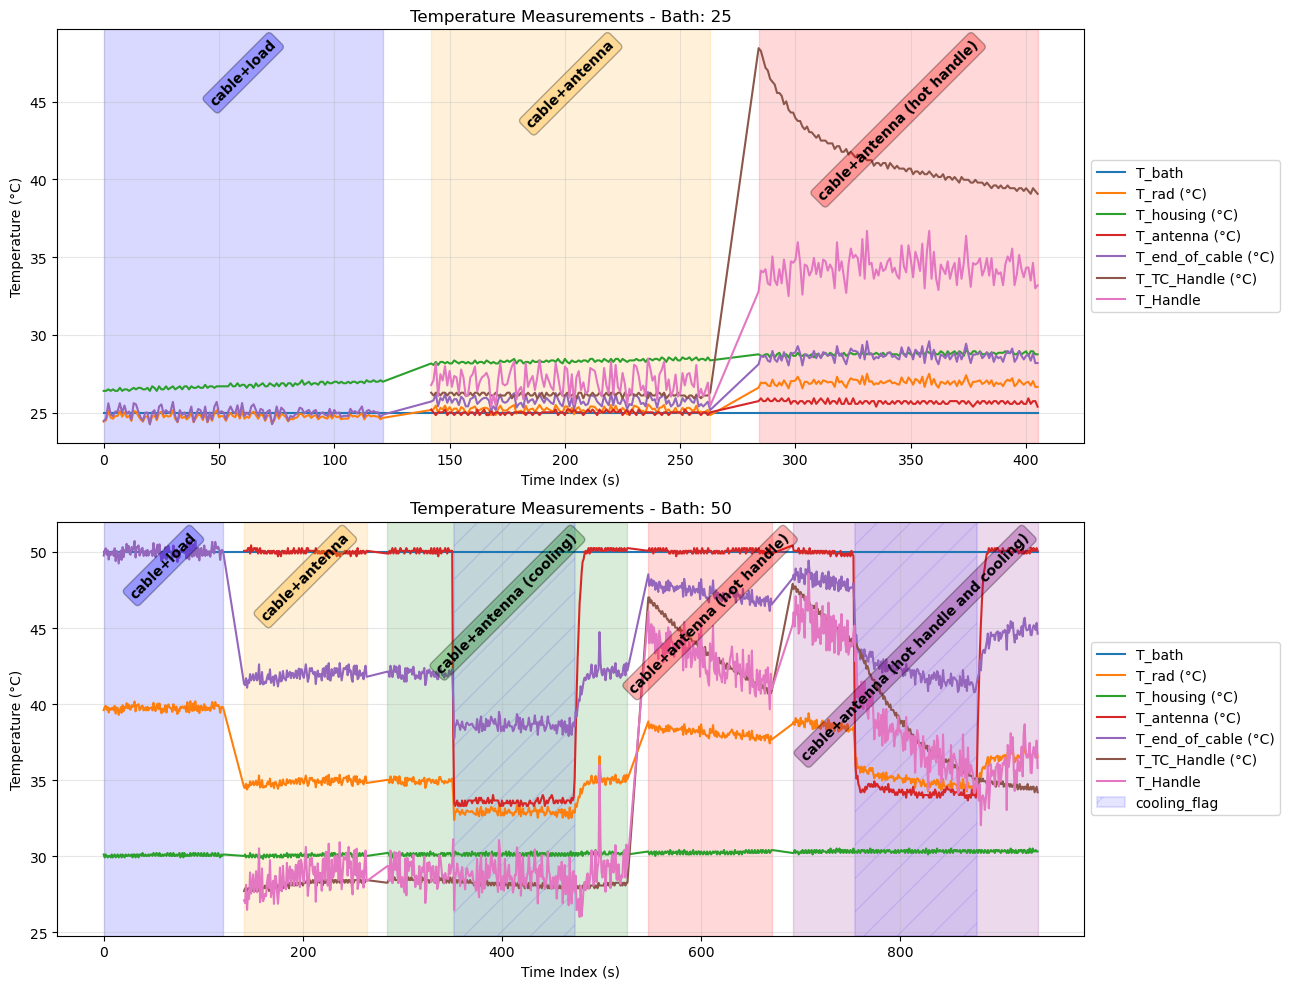

In [28]:

# Filter out classes with asterisks and get valid classes for each condition
all_X_clean = all_X[~all_X['class'].str.contains(r'\*', na=False)].copy()

# Remove rows where class is None
all_X_clean = all_X_clean[all_X_clean['class'].notna()].copy()

print("Valid classes by condition:")
conditions = sorted(all_X_clean['condition'].unique())

for cond in conditions:
    print(f"\nCondition: {cond}")
    print(all_X_clean[all_X_clean['condition'] == cond]['class'].value_counts())

all_X_clean.loc[all_X_clean['class'] == 'cable+load', "T_antenna"] = None
all_X_clean.loc[all_X_clean['class'] == 'cable+load', "T_TC_Handle"] = None
all_X_clean.loc[all_X_clean['class'] == 'cable+load', "T_Handle"] = None


class_order = ["cable+load", "cable+antenna", "cable+antenna (cooling)", "cable+antenna (hot handle)", "cable+antenna (hot handle and cooling)"]
class_colors = {
    'cable+load': 'blue',
    'cable+antenna': 'orange',
    'cable+antenna (cooling)': 'green',
    'cable+antenna (hot handle)': 'red',
    'cable+antenna (hot handle and cooling)': 'purple'
}
variables = ['T_bath', 'T_rad', 'T_housing', 'T_antenna', 'T_end_of_cable', 'T_TC_Handle', 'T_Handle']
plot_all_conditions(
    all_X_clean,
    variables,
    labels,
    class_order,
    class_colors,
    gap_duration=20,
    yscale=1,
    cooling_flag_col='cooling_flag_2',
    time_index_col='time_index_2',
    title_prefix="Temperature Measurements - Bath: ",
    ylabel="Temperature (°C)"
)

## Recover T_tissue 

In [29]:
def T_tissue_with_handle(T_eoc, T_handle, T_antenna, tau_handle, tau_antenna):
    # return (T_eoc - T_bath*tau_antenna*tau_handle - T_antenna*tau_handle*(1 - tau_antenna)) / (1 - tau_handle)
    return (T_eoc - T_antenna*tau_handle*(1 - tau_antenna) - T_handle*(1-tau_handle)) / (tau_antenna*tau_handle)


all_X["T_tissue"] = T_tissue_with_handle(
    all_X["T_end_of_cable"],
    all_X["T_TC_Handle"],
    all_X["T_antenna"],
    tau_h,
    tau_a
)


Valid classes by condition:

Condition: 25
class
cable+load                    122
cable+antenna                 122
cable+antenna (hot handle)    122
Name: count, dtype: int64

Condition: 50
class
cable+antenna (hot handle and cooling)    247
cable+antenna (cooling)                   242
cable+antenna (hot handle)                125
cable+antenna                             124
cable+load                                121
Name: count, dtype: int64
Axes(0.125,0.53;0.775x0.35)

Condition 25 - Data summary by class:
  cable+load: 122 points, time range: 0.0 - 121.0 s
  cable+antenna: 122 points, time range: 142.0 - 263.0 s
  cable+antenna (hot handle): 122 points, time range: 284.0 - 405.0 s
Axes(0.125,0.11;0.775x0.35)

Condition 50 - Data summary by class:
  cable+load: 121 points, time range: 0.0 - 120.0 s
  cable+antenna: 124 points, time range: 141.0 - 264.0 s
  cable+antenna (cooling): 242 points, time range: 285.0 - 526.0 s
  cable+antenna (hot handle): 125 points, time range: 547

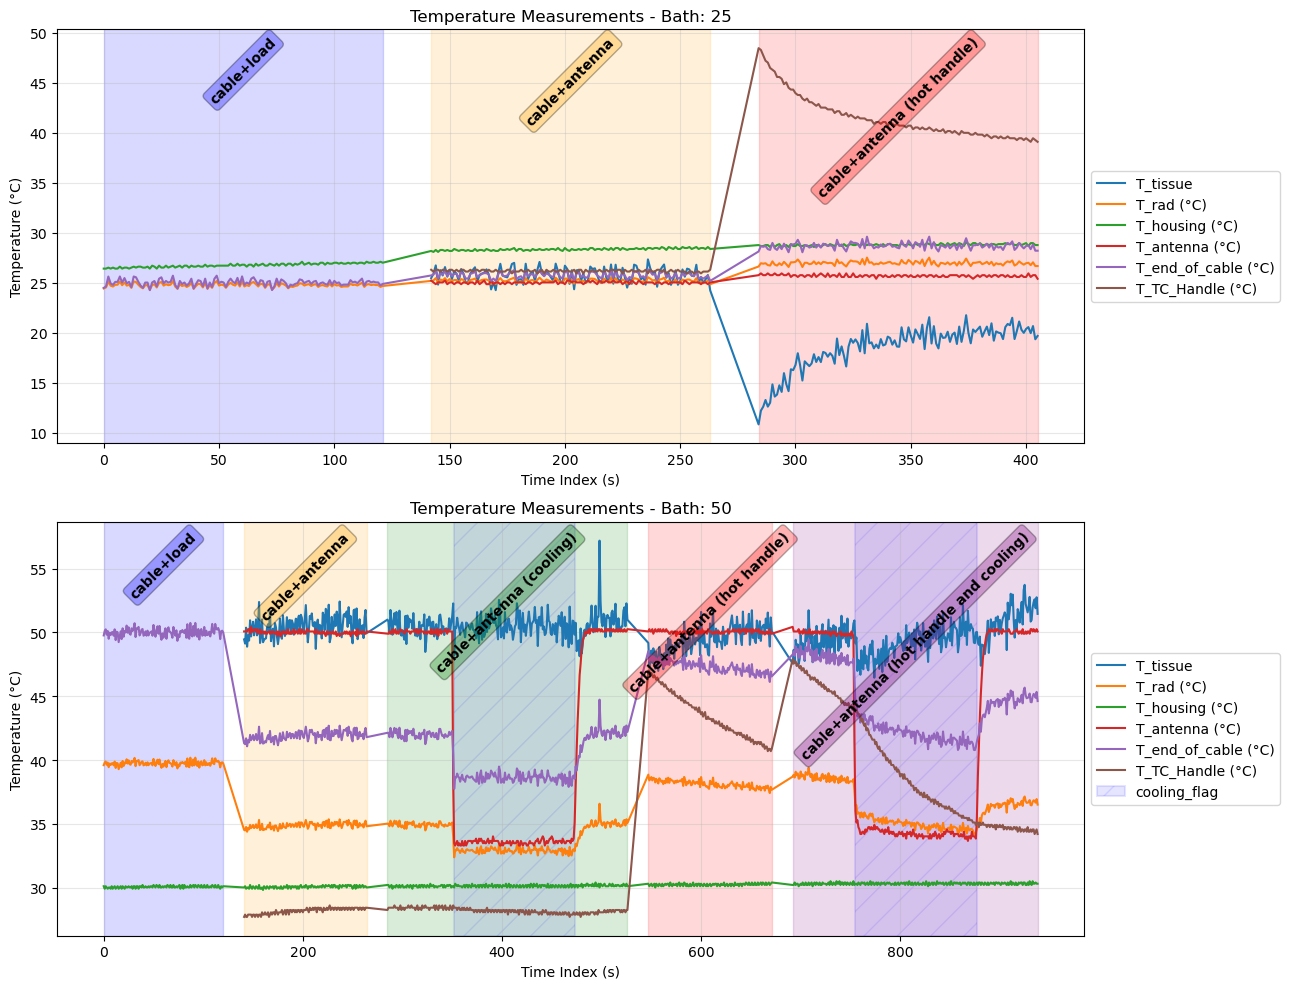

In [30]:

# Filter out classes with asterisks and get valid classes for each condition
all_X_clean = all_X[~all_X['class'].str.contains(r'\*', na=False)].copy()

# Remove rows where class is None
all_X_clean = all_X_clean[all_X_clean['class'].notna()].copy()

print("Valid classes by condition:")
conditions = sorted(all_X_clean['condition'].unique())

for cond in conditions:
    print(f"\nCondition: {cond}")
    print(all_X_clean[all_X_clean['condition'] == cond]['class'].value_counts())

all_X_clean.loc[all_X_clean['class'] == 'cable+load', "T_antenna"] = None
all_X_clean.loc[all_X_clean['class'] == 'cable+load', "T_TC_Handle"] = None
all_X_clean.loc[all_X_clean['class'] == 'cable+load', "T_tissue"] = None


class_order = ["cable+load", "cable+antenna", "cable+antenna (cooling)", "cable+antenna (hot handle)", "cable+antenna (hot handle and cooling)"]
class_colors = {
    'cable+load': 'blue',
    'cable+antenna': 'orange',
    'cable+antenna (cooling)': 'green',
    'cable+antenna (hot handle)': 'red',
    'cable+antenna (hot handle and cooling)': 'purple'
}
variables = ['T_tissue', 'T_rad', 'T_housing', 'T_antenna', 'T_end_of_cable', 'T_TC_Handle']
plot_all_conditions(
    all_X_clean,
    variables,
    labels,
    class_order,
    class_colors,
    gap_duration=20,
    yscale=1,
    cooling_flag_col='cooling_flag_2',
    time_index_col='time_index_2',
    title_prefix="Temperature Measurements - Bath: ",
    ylabel="Temperature (°C)"
)

In [57]:
print(class_order)
for cond in conditions:
    print(cond, all_X_clean[all_X_clean['condition'] == cond]['class'].unique())

['cable+load', 'cable+antenna', 'cable+antenna (cooling)', 'cable+antenna (hot handle)', 'cable+antenna (hot handle and cooling)']
25 ['cable+load' 'cable+antenna' 'cable+antenna (hot handle)']
50 ['cable+load' 'cable+antenna' 'cable+antenna (cooling)'
 'cable+antenna (hot handle)' 'cable+antenna (hot handle and cooling)']


In [58]:
def T_tissue_antenna_and_handle(T_rad, T_antenna, T_handle, tau_antenna, tau_handle):
    T_tissue = (T_rad - T_antenna*tau_handle*(1-tau_antenna) - T_handle*(1-tau_handle))/(tau_antenna * tau_handle)
    return T_tissue

In [64]:
for cond in conditions:
    for class_name in class_order:
        mask = (all_X_clean['condition'] == cond) & (all_X_clean['class'] == class_name)
        class_data = all_X_clean[mask]
        V_rad_tot = class_data['V_rad_tot'] / 1000
        V_housing = class_data['V_housing'] / 1000

        T_housing = T_housing_func(V_housing, HousingSlope, HousingOffset)
        T_rad = T_rad_func(V_rad_tot, T_housing, RadOffsetChange, RadOffset0, RadSlopeChange, RadSlope0)

        if class_name == "cable+load":
            T_cable = None
            T_tissue = T_rad
            T_antenna = None
            T_handle = None
        elif "cable+antenna" in class_name:
            T_antenna = int(cond)
            T_handle = 27
            T_tissue = T_tissue_antenna_and_handle(T_rad, T_antenna, T_handle, tau_antenna, tau_handle)

        all_X_clean.loc[mask, 'T_rad'] = T_rad
        all_X_clean.loc[mask, 'T_tissue'] = int(cond)
        all_X_clean.loc[mask, 'T_housing'] = T_housing
        all_X_clean.loc[mask, 'T_antenna'] = T_antenna
        all_X_clean.loc[mask, 'T_handle'] = T_handle


Axes(0.125,0.53;0.775x0.35)

Condition 25 - Data summary by class:
  cable+load: 122 points, time range: 0.0 - 121.0 s
  cable+antenna: 122 points, time range: 142.0 - 263.0 s
  cable+antenna (hot handle): 122 points, time range: 284.0 - 405.0 s
Axes(0.125,0.11;0.775x0.35)

Condition 50 - Data summary by class:
  cable+load: 121 points, time range: 0.0 - 120.0 s
  cable+antenna: 124 points, time range: 141.0 - 264.0 s
  cable+antenna (cooling): 242 points, time range: 285.0 - 526.0 s
  cable+antenna (hot handle): 125 points, time range: 547.0 - 671.0 s
  cable+antenna (hot handle and cooling): 247 points, time range: 692.0 - 938.0 s


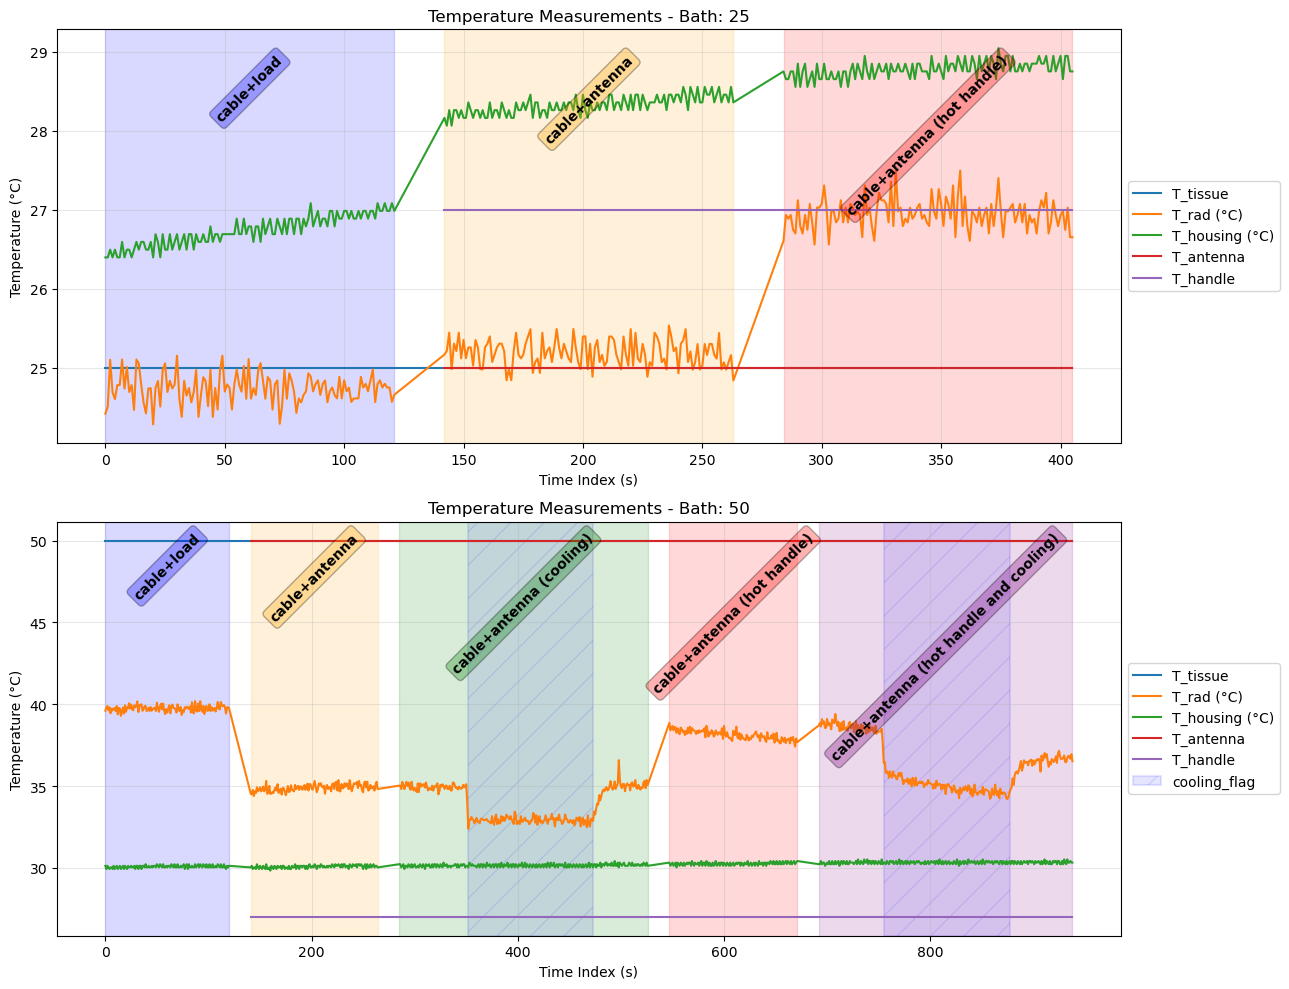

In [65]:
variables = ['T_tissue', 'T_rad', 'T_housing', 'T_antenna', 'T_handle']
plot_all_conditions(
    all_X_clean,
    variables,
    labels,
    class_order,
    class_colors,
    gap_duration=20,
    cooling_flag_col='cooling_flag_2',
    time_index_col='time_index_2',
    yscale=1,
    title_prefix="Temperature Measurements - Bath: ",
    ylabel="Temperature (°C)"
)

In [20]:
# Calculate average Temperature for each condition and class
print("Average temperatures by condition and class:")
print("="*50)

for condition in sorted(all_X_clean['condition'].unique()):
    print(f"\nCondition: {condition}")
    condition_data = all_X_clean[all_X_clean['condition'] == condition]
    avg_temperatures = condition_data.groupby('class')[['T_rad', 'T_housing', 'T_tissue']].mean()

    print("Microvolts:")
    print(avg_temperatures.round(1))
    print("-" * 30)

Average temperatures by condition and class:

Condition: 50
Microvolts:
         T_rad  T_housing  T_tissue
class                              
antenna   41.3       31.4      10.5
load      49.4       30.5      49.4
------------------------------


In [30]:
def T_tissue_antenna_and_handle(T_rad, T_antenna, T_handle, tau_antenna, tau_handle):
    T_tissue = (T_rad - T_antenna*tau_handle*(1-tau_antenna) - T_handle*(1-tau_handle))/(tau_antenna * tau_handle)
    print("T_rad:", T_rad)
    print("T_antenna:", T_antenna)
    print("T_handle:", T_handle)
    print("tau antenna:", tau_antenna)
    print("tau handle:", tau_handle)
    print("T_antenna * tau_handle * (1 - tau_antenna):", T_antenna * tau_handle * (1 - tau_antenna))
    print("T_handle * (1 - tau_handle):", T_handle * (1 - tau_handle))
    print("tau_handle * (1 - tau_antenna):", tau_handle * (1 - tau_antenna))
    print("(1 - tau_handle):", (1 - tau_handle))
    print("T_tissue:", T_tissue)
    return T_tissue

T_t = T_tissue_antenna_and_handle(avg_temperatures.loc["antenna","T_rad"], T_antenna=50, T_handle=24, tau_antenna=tau_antenna, tau_handle=tau_handle)

T_rad: 41.31757155971723
T_antenna: 50
T_handle: 24
tau antenna: 0.7646743726071411
tau handle: 0.882619390947178
T_antenna * tau_handle * (1 - tau_antenna): 10.385148096187384
T_handle * (1 - tau_handle): 2.817134617267728
tau_handle * (1 - tau_antenna): 0.20770296192374765
(1 - tau_handle): 0.117380609052822
T_tissue: 41.65743733182419


## Derive Transmissions from radiometric values

$$
T_{\text{rad}} = T_{\text{bath}} \cdot \tau + T_{\text{DUT}} \cdot (1 - \tau)
$$

$$
\tau = \frac{T_{\text{rad}} - T_{\text{DUT}}}{T_{\text{bath}} - T_{\text{DUT}}}
$$


In [120]:
# tau = (T_cable - T_rad) / (T_cable - T_bath)
T_bath = 50
T_cable = 25

tau_cable_derived = (T_cable - avg_temperatures.loc["cable", "T_rad"]) / (T_cable - T_bath)
# tau_diplexer_derived = (T_cable - avg_temperatures.loc["diplexer (no connector)", "T_rad"]) / (T_cable - T_bath)
tau_diplexer_connector_derived = (T_cable - avg_temperatures.loc["diplexer", "T_rad"]) / (T_cable - T_bath)
tau_diplexer_connector_cable_derived = (T_cable - avg_temperatures.loc["diplexer + cable", "T_rad"]) / (T_cable - T_bath)

print(f"tau_cable_derived: {tau_cable_derived:.4f} ({100*(tau_cable_derived-tau_cable)/tau_cable:.2f}% vs original)")
# print(f"tau_diplexer_derived: {tau_diplexer_derived:.4f} ({100*(tau_diplexer_derived-tau_diplexer)/tau_diplexer:.2f}% vs original)")
print(f"tau_diplexer_connector_derived: {tau_diplexer_connector_derived:.4f} ({100*(tau_diplexer_connector_derived-tau_diplexer_connector)/tau_diplexer_connector:.2f}% vs original)")
print(f"tau_diplexer_connector_cable_derived: {tau_diplexer_connector_cable_derived:.4f} ({100*(tau_diplexer_connector_cable_derived-tau_diplexer_connector_cable)/tau_diplexer_connector_cable:.2f}% vs original)")

tau_cable_derived: 0.5882 (-0.11% vs original)
tau_diplexer_connector_derived: 0.6774 (-25.16% vs original)
tau_diplexer_connector_cable_derived: 0.4243 (-20.75% vs original)


In [121]:
tau_total_derived = tau_cable_derived * tau_diplexer_connector_derived

for cond in conditions:
    for class_name in class_order:
        mask = (all_X_clean['condition'] == cond) & (all_X_clean['class'] == class_name)
        class_data = all_X_clean[mask]
        V_rad_tot = class_data['V_rad_tot'] / 1000
        V_housing = class_data['V_housing'] / 1000

        T_housing = T_housing_func(V_housing, HousingSlope, HousingOffset)
        T_rad = T_rad_func(V_rad_tot, T_housing, RadOffsetChange, RadOffset0, RadSlopeChange, RadSlope0)

        if class_name == "cable":
            T_cable = 25
            T_tissue = T_tissue_cable_func(T_rad, T_cable, tau_cable)
        elif class_name == "load":
            T_cable = None
            T_tissue = T_rad
        elif class_name == "diplexer":
            T_cable = 25
            T_tissue = T_tissue_cable_func(T_rad, T_cable, tau_diplexer_connector_derived)
        elif class_name == "diplexer + cable":
            T_cable = 25
            T_tissue = T_tissue_cable_func(T_rad, T_cable, tau_total_derived)

        all_X_clean.loc[mask, 'T_rad'] = T_rad
        all_X_clean.loc[mask, 'T_tissue'] = T_tissue
        all_X_clean.loc[mask, 'T_housing'] = T_housing
        all_X_clean.loc[mask, 'T_cable'] = T_cable



Condition 50 - Data summary by class:
  load: 123 points, time range: 0.0 - 122.0 s
  cable: 130 points, time range: 143.0 - 272.0 s
  diplexer: 138 points, time range: 293.0 - 430.0 s
  diplexer + cable: 132 points, time range: 451.0 - 582.0 s


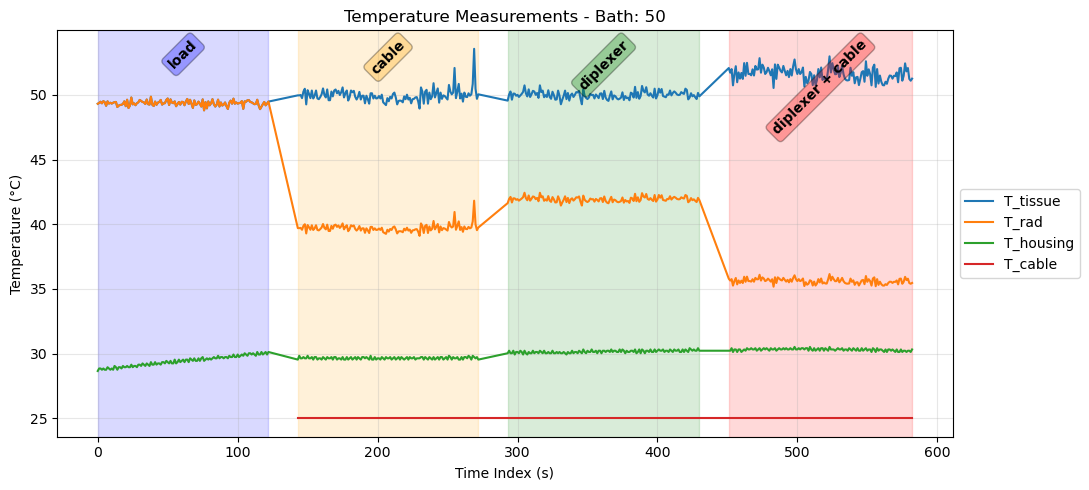

<Figure size 640x480 with 0 Axes>

In [122]:
variables = ['T_tissue', 'T_rad', 'T_housing', 'T_cable']
plot_all_conditions(
    all_X_clean,
    variables,
    labels,
    class_order,
    class_colors,
    gap_duration=20,
    cooling_flag_col='cooling_flag_2',
    time_index_col='time_index_2',
    yscale=1,
    title_prefix="Temperature Measurements - Bath: ",
    ylabel="Temperature (°C)"
)

In [123]:
# Calculate average Temperature for each condition and class
print("Average temperatures by condition and class:")
print("="*50)

for condition in sorted(all_X_clean['condition'].unique()):
    print(f"\nCondition: {condition}")
    condition_data = all_X_clean[all_X_clean['condition'] == condition]
    avg_temperatures = condition_data.groupby('class')[['T_rad', 'T_housing', 'T_tissue']].mean()

    print("Microvolts:")
    print(avg_temperatures.round(1))
    print("-" * 30)

Average temperatures by condition and class:

Condition: 50
Microvolts:
                  T_rad  T_housing  T_tissue
class                                       
cable              39.7       29.6      50.0
diplexer           41.9       30.2      50.0
diplexer + cable   35.6       30.3      51.6
load               49.4       29.4      49.4
------------------------------
